# Deep sequencing analysis for saturation gRNA data

# QC module

## 1 Functions and module

### 1.1 Modules

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import regex

### 1.2 Functions

In [32]:
def Combine_DataFrame_Info(input_reads_df, input_gRNA_df, input_sample_df):
    # this function take reads, gRNA info df and sample df, and merge to a final data df
    # merge reads df with gRNA info df. Only gRNA match with reference will be selected
    temp_df = input_reads_df.merge(
        input_gRNA_df, how='inner', on=['gRNA'], sort=True)
    # merge reads df with sample info df
    output_df = temp_df.merge(
        input_sample_df, how='inner', on=['Sample_ID'], sort=True)
    output_df['gRNA_clonalbarcode'] = output_df['gRNA'] + '_' + output_df['Clonal_barcode']
    return (output_df)

In [33]:
def Generate_Raw_Dataframe(input_read_adress, input_gRNA_address, input_experiment_address,
                           barcode_pattern=False):
    # this function take three dataframe address, do some cleaning and combined them into one dataframe
    temp_c = ['gRNA', 'Clonal_barcode', 'Sample_ID', 'Count']
    combined_df = pd.read_csv(input_read_adress, index_col=0, header=None,
                              skiprows=[0,], names=temp_c)
    # Read gRNA and spike in info
    gRNA_info_df = pd.read_csv(input_gRNA_address, header=None, skiprows=[0,],
                               names=['Targeted_gene_name', 'gRNA'])
    # I drop duplicated gRNA information
    gRNA_info_df.drop_duplicates(inplace=True)
    # add identity to distinguish gRNA and spikein
    gRNA_info_df['Identity'] = gRNA_info_df.apply(
        lambda x: x['Targeted_gene_name'] if (
            'Spike' in x['Targeted_gene_name']) else 'gRNA', axis=1)
    # added number for sgRNAs for the same targeting gene
    gRNA_info_df['Numbered_gene_name'] = gRNA_info_df['Targeted_gene_name']
    mask = gRNA_info_df['Numbered_gene_name'].duplicated(keep=False)
    gRNA_info_df.loc[mask, 'Numbered_gene_name'] += '_'+gRNA_info_df.groupby(
        'Numbered_gene_name').cumcount().add(1).astype(str)
    # read experiment information
    exp_info_df = pd.read_csv(
        input_experiment_address)

    # rename column names to make it consistent
    exp_info_df.rename(columns = {'Sample ID':'Sample_ID','Mouse_Genotype':'Mouse_genotype',
                                 'Virus_Titer':'Virus_titer','Time_After_Tumor_Initiation(wks)':'Time_after_tumor_initiation',
                                 'Total_Lung_Weight(g)':'Total_lung_weight'}, inplace = True)
    Output_df = Combine_DataFrame_Info(combined_df,gRNA_info_df,exp_info_df)
    if barcode_pattern:
    # Now I check the barcode of gRNA to see if they are saturation barcode
    # temp_pattern = regex.compile('(.{3}A.{2}C.{4}C.{3})')
        temp_pattern = regex.compile(barcode_pattern)
        Output_df['Saturation_barcode'] = ['Spikein_barcode']*Output_df.shape[0]
        temp_list = []
        for temp_b in Output_df.loc[Output_df['Identity']=='gRNA','Clonal_barcode']:
            if temp_pattern.search(temp_b):
                temp_list.append('Real')
            else:
                temp_list.append('Fake')
        Output_df.loc[Output_df['Identity']=='gRNA', 'Saturation_barcode'] = temp_list
        Output_df = Output_df[Output_df['Saturation_barcode']!='Fake']
    print('There are totally {} reads'.format(combined_df['Count'].sum()))
    print('There are {} reads mapped to ref gRNA, which is about {}'.format(
        Output_df['Count'].sum(), Output_df ['Count'].sum()/combined_df['Count'].sum()))
    return (Output_df)

In [34]:
def Spikein_summary(input_df,input_spikein_name,input_cell_number):
# this function extract spike reads for each kind in each sample
    temp_df = input_df[input_df['Targeted_gene_name'].isin(input_spikein_name)] # select spike in rows
    temp_df = temp_df.groupby(['Sample_ID','Targeted_gene_name'],as_index = False).agg(
        Unique_spikein_barcode_number = pd.NamedAgg('Clonal_barcode',aggfunc = lambda x: len(x)), # number of different spike-in barcode
        Count = pd.NamedAgg('Count',aggfunc = np.sum)
    )
    temp_df['Cell_per_read'] = input_cell_number/temp_df['Count']
    temp_df['Amplification'] = temp_df.Count/temp_df.Unique_spikein_barcode_number
    return(temp_df)

In [35]:
# calculate the combined spikein metrics for each sample
def Cal_Spike_in_Ratio(x):
    d = {}
    temp_name_list = spikein_name_list # this is spike in name_list 
    temp_vect = x[['Targeted_gene_name','Count']]
    s1_value = x[x['Targeted_gene_name'] == temp_name_list[0]]['Count'].values[0]
    s2_value = x[x['Targeted_gene_name'] == temp_name_list[1]]['Count'].values[0]
    s3_value = x[x['Targeted_gene_name'] == temp_name_list[2]]['Count'].values[0]
    d['Spikein1'] = s1_value
    d['Spikein2'] = s2_value
    d['Spikein3'] = s3_value
    d['Mean_count'] = (s1_value+s2_value+s3_value)/3 # mean count for spike in 
    s1_s2_ratio =  s1_value/s2_value# spikein 1/ spikein 2 ratio
    s1_s3_ratio =  s1_value/s3_value# spikein 1/ spikein 2 ratio
    d['s1_s2_ratio'] = s1_s2_ratio
    d['s1_s3_ratio'] = s1_s3_ratio
    d['max_least_ratio'] = sorted([s1_value,s2_value,s3_value])[-1]/sorted([s1_value,s2_value,s3_value])[0]
    return pd.Series(d, index=list(d.keys())) 

In [36]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 6)

In [37]:
def Generate_Simple_Sample_Summary(input_df,input_spikein_df):
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_genotype','Virus_titer','Total_lung_weight','Mouse_Ear_Tag'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum)) # total reads
    spikein_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # spike in name should be ordered here
    temp_spike_df = input_spikein_df.set_index('Sample_ID')
    temp_df0['Spike1_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[0]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike2_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[1]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike3_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[2]].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    return(temp_df0)

In [38]:
def Generate_Conversion_factor(input_spike_df, input_candidate_list, input_spike_in_list,temp_spikein_cell_number):
    # this function generate a df storing cell number per reads
    # input_spike_df is the df contain the spikein information (spikein_ratio_df)
    # temp_spikein_cell_number is the cell number for each spike in added into sample (usually it is 100K)
    # for most sample, I will use temp_spikein_cell_number/ mean(spike in reads)
    # input_candidate_list is the list of sample id whose spikein needed special treatment
    # temp_spikein_cell_number specify which spike in will be use for each sample ID who need special treatment
    input_dic = dict(zip(input_candidate_list, input_spike_in_list))
    temp_dic = {}
    for index,row in input_spike_df.iterrows():
        temp_id = row['Sample_ID']
        if temp_id in input_dic.keys():
            # print(row[input_dic.get(id)])
            temp_value = row[input_dic.get(temp_id)].mean()
        else:
            temp_value = row['Mean_count']
        temp_dic[temp_id] = temp_spikein_cell_number/temp_value
    temp_df = pd.DataFrame({'Sample_ID':temp_dic.keys(),
                       'Cell_number_per_read':temp_dic.values()})
    temp_df['Correction_for_spikein'] = temp_df['Sample_ID'].apply(lambda x: 'Yes' if (x in input_candidate_list) else 'No')
    return(temp_df)
        

In [39]:
def Final_df_Generation(input_df,input_conversion_factor_df):
    # input_df is the dataframe input
    # input_conversion_factor_df is the dictionary that store the the cell number per reads
    temp_df = input_df.merge(input_conversion_factor_df, on ='Sample_ID')
    temp_df['Cell_number'] = temp_df['Count']*temp_df['Cell_number_per_read']
    return(temp_df)

In [40]:
# calculate the summary metrics for each sample
def Cal_Sample_Summary(x):
    d = {}
    temp_vect = x['Cell_number']
    if type (temp_vect) == 'int':
        temp_vect = [temp_vect]
    d['gRNA_recovered'] = len(x['gRNA'].unique())
    d['TTB'] = sum(temp_vect) # total mutational burdern 
    d['TTN'] = len(temp_vect) # this is total tumor number
    return pd.Series(d, index=list(d.keys())) 

In [41]:
def Generate_Sample_Summary(input_df, input_spikein_check_df,input_cell_number_cutoff,input_read_cutoff):
    # input_cell_number_cutoff is the cell number cutoff
    # input_rad_cutoff is the read cutoff
    # Total reads does not restricted to gRNA or cell number cutoff
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_Ear_Tag','Mouse_genotype', 'Sex',
         'Time_after_tumor_initiation', 'Total_lung_weight', 'Virus_titer','Correction_for_spikein','Cell_number_per_read'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum))
    temp_df0 = temp_df0.merge(input_spikein_check_df[['Sample_ID','Mean_count','max_least_ratio']],on = 'Sample_ID') # merge spike in info
    temp_df0['Spikein_read_ratio'] = (temp_df0['Mean_count']*3)/temp_df0['TTR']
    # filter input data
    temp_input = input_df[(input_df['Cell_number']>=input_cell_number_cutoff)&(input_df['Count']>input_read_cutoff)]
    # I only consider non-spikein gRNA
    temp_df1 = temp_input[temp_input['Identity']=='gRNA'].groupby(
        ['Sample_ID'],as_index = False).apply(
        Cal_Sample_Summary)
    temp_df1['TTB_million'] = temp_df1['TTB']/1000000
    # merge sample and gRNA information    
    temp_df1 = temp_df1.merge(temp_df0,on = 'Sample_ID',how = 'right')
    return(temp_df1)

In [42]:
def Plot_Correlation_Plot(input_df,unit_name, trait_of_interest,input_method,color,output_address,linkage_method):
    # cluster with indicator bar of sex and genotype
    temp_cor_matrix = Generate_DF_for_Correlation(input_df,unit_name,trait_of_interest).corr(method=input_method, min_periods=1)
    myvar = pd.Series(temp_cor_matrix.columns)
    tt = input_df[['Sample_ID','Sex','Mouse_genotype']].drop_duplicates()
    temp_dict_row = dict(zip(tt.Sample_ID, tt.Sex))
    temp_dict_col = dict(zip(tt.Sample_ID, tt.Mouse_genotype))
    row_color_list = myvar.map(temp_dict_row).map({'F':'r','M':'g'})
    col_color_list = myvar.map(temp_dict_col).map({'KT':'k','KTC':'b'})
    mask = temp_cor_matrix.isnull()
    g = sns.clustermap(temp_cor_matrix, row_colors=row_color_list.values,
                       col_colors=col_color_list.values,mask = mask, method = linkage_method,cmap=color,xticklabels=True, yticklabels=True)
    g.fig.suptitle('Correlation of {} for {} across samples'.format(trait_of_interest,unit_name)) 
    if output_address:
        g.savefig(output_address)

In [43]:
def Generate_DF_for_Correlation(input_df, unit_name, trait_of_interest):
    temp_name_list = input_df['Sample_ID'].unique()
    temp_column_list = [unit_name,trait_of_interest]

    temp_1 = input_df[input_df['Sample_ID'] == temp_name_list[0]][temp_column_list]
    temp_1.rename(columns={trait_of_interest:temp_name_list[0]}, inplace=True)
    for x in temp_name_list[1:]:
        temp_2 = input_df[input_df['Sample_ID'] == x][temp_column_list]
        temp_2.rename(columns={trait_of_interest:x}, inplace=True)
        temp_1 = temp_1.merge(temp_2,on=unit_name,how = 'outer')
    return(temp_1)

----

## 2 Input and output address

In [44]:
# combined barcode dataframe address
parent_address = "Data/Saturation/"
combined_df_address = parent_address + "gRNA_clonalbarcode_combined_saturation.csv"
# gRNA information address
gRNA_info_address = parent_address + "gRNA_information_saturation.csv"
# experimental information address
exp_info_address = parent_address + "Saturation_information_standardized.csv"

In [45]:
figure_output_address = "Figure/Saturation/"
Final_df_output_address = parent_address + "Saturation_final_df.csv"
sample_summary_address = parent_address + "Saturation_sample_summary_df.csv"
sample_discarded_list_address = parent_address + "Discarded_sample_list_for_saturation.txt"

-----

## 3 Raw data processing

### 3.1 Explaination and note
* <font size="5"> 3.2 only gRNAs matched to existing gRNA or spike in are retained</font>
* <font size="5"> 3.3 I want to know if any spikein has unexpected high or low read in certain sample</font>
* <font size="5"> 3.2 I only consider barcode pattern that matched the Jackie ID pattern</font>

### 3.2 raw data Generation

In [57]:
raw_summary_df = Generate_Raw_Dataframe(combined_df_address,gRNA_info_address,exp_info_address,barcode_pattern='(.{3}A.{2}C.{4}C.{3})')

There are totally 97682526 reads
There are 94814371 reads mapped to ref gRNA, which is about 0.9706379931247888


## 4 Spikein QC

### 4.1 Count spikein read numbers and ratio

In [58]:
# I first check if spikes have similar read counts 
spikein_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # spike in name should be ordered here
spikein_df = Spikein_summary(raw_summary_df,spikein_name_list,100000)

In [59]:
spikein_df.head()

,Sample_ID,Targeted_gene_name,Unique_spikein_barcode_number,Count,Cell_per_read,Amplification
0,LA58_10,tuba-seq-v2_Spike-in-1,162,308,324.675325,1.901235
1,LA58_10,tuba-seq-v2_Spike-in-2,186,377,265.251989,2.026882
2,LA58_10,tuba-seq-v2_Spike-in-3,531,2422,41.288192,4.561205
3,LA58_11,tuba-seq-v2_Spike-in-1,227,867,115.340254,3.819383
4,LA58_11,tuba-seq-v2_Spike-in-2,313,1011,98.911968,3.230032


In [60]:
spikein_ratio_df = spikein_df.groupby(['Sample_ID'],as_index = False).apply(Cal_Spike_in_Ratio) # the ratio of spike in

In [61]:
spikein_ratio_df.head()

,Sample_ID,Spikein1,Spikein2,Spikein3,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio
0,LA58_10,308.0,377.0,2422.0,1035.666667,0.816976,0.127168,7.863636
1,LA58_11,867.0,1011.0,545.0,807.666667,0.857567,1.590826,1.855046
2,LA58_12,914.0,972.0,818.0,901.333333,0.940329,1.117359,1.188264
3,LA58_13B,959.0,1063.0,811.0,944.333333,0.902164,1.182491,1.310727
4,LA58_14B,914.0,1381.0,722.0,1005.666667,0.661839,1.265928,1.912742


### 4.2 Find samples with unusual spike in ratio

Text(0, 0.5, 's1/s3')

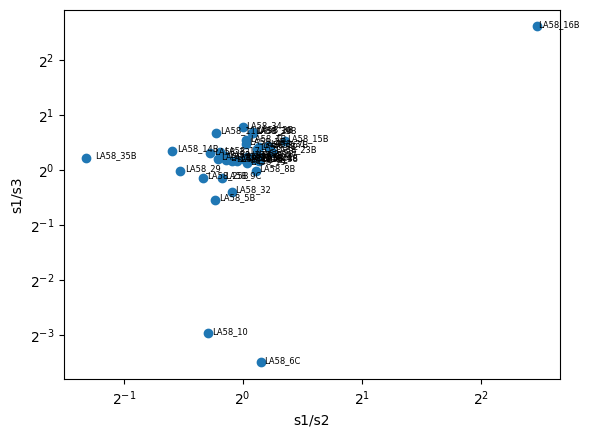

In [62]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
plt.xscale('log',base = 2)
plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

* <font size="5" color =  black> Apparently sample <mark>35B, 10, 6C and 16B </mark> have relatively distorted ratio between spikein</font>

### 4.3 Find bad spike in for those samples

#### 4.3.1 Method 1

In [63]:
input_ratio_cutoff = 3 # this is the cutoff 
temp_bad_list = spikein_ratio_df.loc[spikein_ratio_df['max_least_ratio']>input_ratio_cutoff,'Sample_ID'].to_list() # list of sample with bad spikein

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])


Text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>3)')

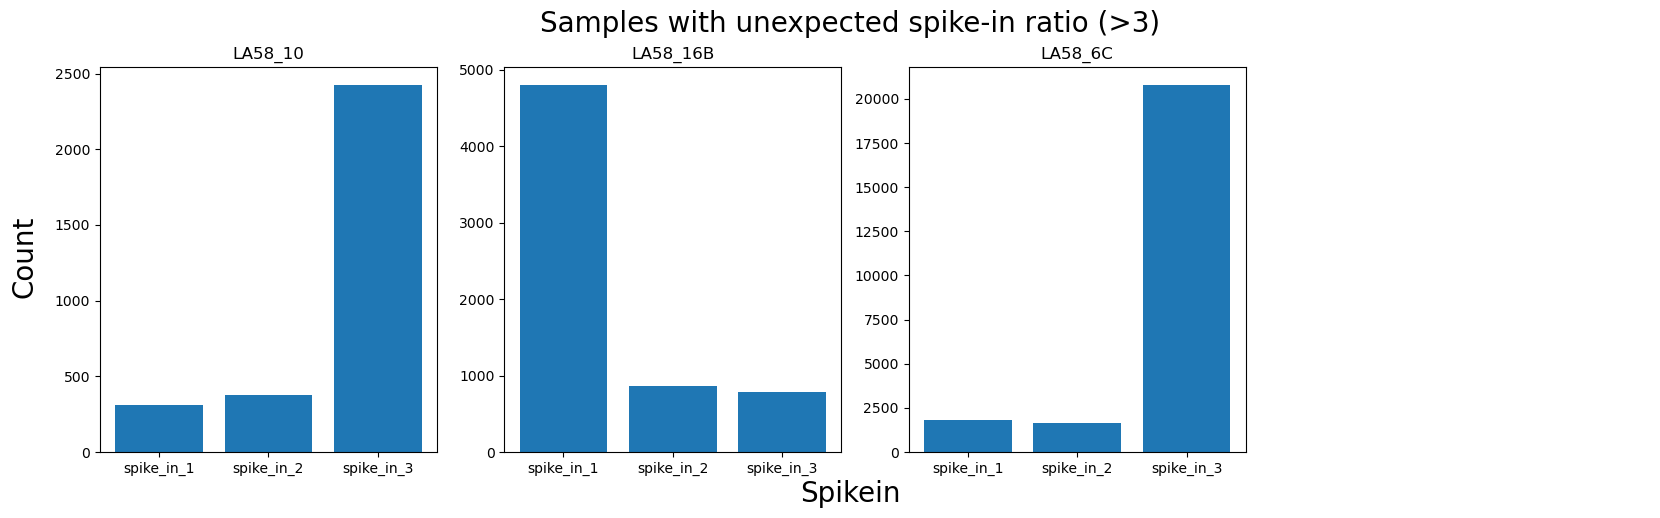

In [64]:
# check the max/min ratio in each sample and print those sample with ratio above certain cutoff
fig1,ax = plt.subplots(math.ceil(len(temp_bad_list)/4), 4, figsize=(20,5*math.ceil(len(temp_bad_list)/4)))
axes = ax.flatten()
for x,y in zip(axes[:len(temp_bad_list)],temp_bad_list):
    temp_df = spikein_df[spikein_df['Sample_ID'] == y]
    x.bar(temp_df['Targeted_gene_name'],temp_df['Count'])
    x.set_title(y)
    x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
for x in axes[len(temp_bad_list):]:
    x.set_axis_off()
fig1.text(0.08, 0.5, 'Count', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.01, 'Spikein', ha='center',fontsize=20)
fig1.text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>{})'.format(input_ratio_cutoff), ha='center',fontsize=20)
# fig1.savefig(figure_output_address+'QC_332.pdf')aa

* <font size="5" color =  black> If we assume only one of the spikein has a problem, the one with extraordinary <mark> high </mark> count seems to be the problematic one</font>

#### 4.3.2 Method 2

In [65]:
temp_summary_df = Generate_Simple_Sample_Summary(raw_summary_df,spikein_df)

In [66]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Virus_titer,Total_lung_weight,Mouse_Ear_Tag,TTR,Spike1_reads_fraction,Spike2_reads_fraction,Spike3_reads_fraction
0,LA58_10,KTC,150K,1.0691,MT2366,1117513,0.000276,0.000337,0.002167
1,LA58_11,KTC,150K,0.9362,MT2369,2867649,0.000302,0.000353,0.000190
2,LA58_12,KTC,150K,0.8861,MT2356,2668853,0.000342,0.000364,0.000306
3,LA58_13B,KTC,150K,0.5849,MT2358,1994498,0.000481,0.000533,0.000407
4,LA58_14B,KTC,150K,0.7982,MT2370,2385678,0.000383,0.000579,0.000303


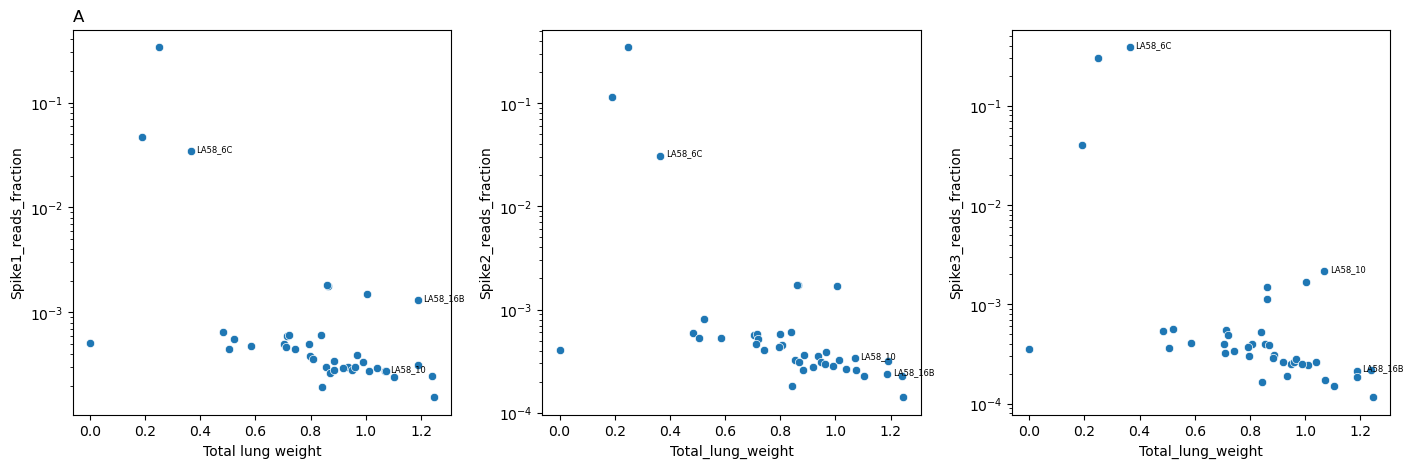

In [67]:
gs = gridspec.GridSpec(1, 17) 
fig1 = plt.figure(figsize=(17,5))

ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike1_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax1)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())


ax1.set_xlabel('Total lung weight')
ax1.set_ylabel(iy)
ax1.set_yscale('log')
ax1.set_title('A', loc ='left')


ax2=fig1.add_subplot(gs[:1, 6:11])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike2_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax2)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())

ax2.set_yscale('log')
# ax2.set_xlabel('Total lung weight')
# ax2.set_ylabel('Total tumor burden (million cells)')
# ax2.set_title('B', loc ='Left')


ax3 = fig1.add_subplot(gs[:1, 12:17])
temp_df = temp_summary_df
ix = 'Total_lung_weight'
iy = 'Spike3_reads_fraction'
sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax3)
temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
label_point(temp_sub[ix],temp_sub[iy], temp_sub['Sample_ID'], plt.gca())

ax3.set_yscale('log')

* <font size="5" color =  black> Here i am plotting for each sample, what is the reads fraction of each spike in </font>
* <font size="5" color =  black> In theory, if the lung weight is higher, we should expected a lower fraction of spikein in the total reads</font>
* <font size="5" color =  black> For sample 6C, all three spike-in fractions seem too high </font>
* <font size="5" color =  black> For sample 10,  spike-in 3 fraction seems too high, which confirmes previous result </font>
* <font size="5" color =  black> For sample 16B,  spike-in 1 fraction seems too high, which confirmes previous result </font>

## 5 Correct Cell per reads

* <font size="5" color =  red> For each sample I generate a conversion factor, which is cell number per reads</font>

In [68]:
temp_bad_list

['LA58_10', 'LA58_16B', 'LA58_6C']

In [69]:
temp = [['Spikein1','Spikein2'],['Spikein2','Spikein3'],['Spikein1','Spikein2']]
conversion_factor_df= Generate_Conversion_factor(spikein_ratio_df,temp_bad_list,temp,100000)

In [70]:
conversion_factor_df.head()

,Sample_ID,Cell_number_per_read,Correction_for_spikein
0,LA58_10,291.970803,Yes
1,LA58_11,123.813454,No
2,LA58_12,110.946746,No
3,LA58_13B,105.894811,No
4,LA58_14B,99.436526,No


In [71]:
Final_df = Final_df_Generation(raw_summary_df,conversion_factor_df)

In [72]:
Final_df.to_csv(Final_df_output_address,index=False)

In [73]:
# Final_df = pd.read_csv(Final_df_output_address)

## 6 Overall sample QC 

### 6.1 Explaination

In [74]:
cell_number_cutoff = 800
Sample_summary_df = Generate_Sample_Summary(Final_df, spikein_ratio_df,cell_number_cutoff,3)

* <font size="5"> I have cutoff for both cell number and read number</font>
* <font size="5"> $N_{sgTG_i,S_j}$ Stands for cell number of sgRNAi targeting a certain gene in mouse sample Sj</font>
* <font size="5"> $TTB_{S_j}$ stands for total tumor burden for a sample Sj </font>
* <font size="5"> $TTB_{S_j}=\sum_{i=1}^{n_{S_j}}N_{sgTG_i,S_j}$ </font>
* <font size="5"> When calculating $TTB_{S_j}$, I can also set a cutoff for a minimal cell number to be considered as real epithelial cells </font>

### 6.2 Plot

* <font size="5" color =  red> For panel A, I just want to show the how many cells each sequencing read represent</font>
* <font size="5" color =  blue> For panel B, most of the dots show positive correlation between tumor burden and tumor weight.</font>
* <font size="5" color =  blue> For panel B, dots deviated are mostly dots with little reads mapped, which has a smaller dot.</font>
* <font size="5" color =  green> For panel C, same as panel C. Here I just want to check if any spike in corrected sample will deviate from the line. Because if the spike-in reads are wrong, they will not follow the general trend</font>

* <font size="5" color =  brown> For panel D, I want to show the spikein ratio and total number of reads mapped to each sample. Three sample has very weird spikein ratio</font>

* <font size="5" color =  orange> For panel E, I want to show the number of gRNA recovered.</font>
* <font size="5" color =  purple> For panel F, I want to check if there is saturation of tumor burden with the increasing of more tumor.</font>

* <font size="5" color =  oliva> For panel G, I want to show the relation between virus titer and TTB.</font>

* <font size="5" color =  oliva> For panel H, I want to show the relation between virus titer and TTN.</font>

Text(0, 0.5, 'Total tumor number)')

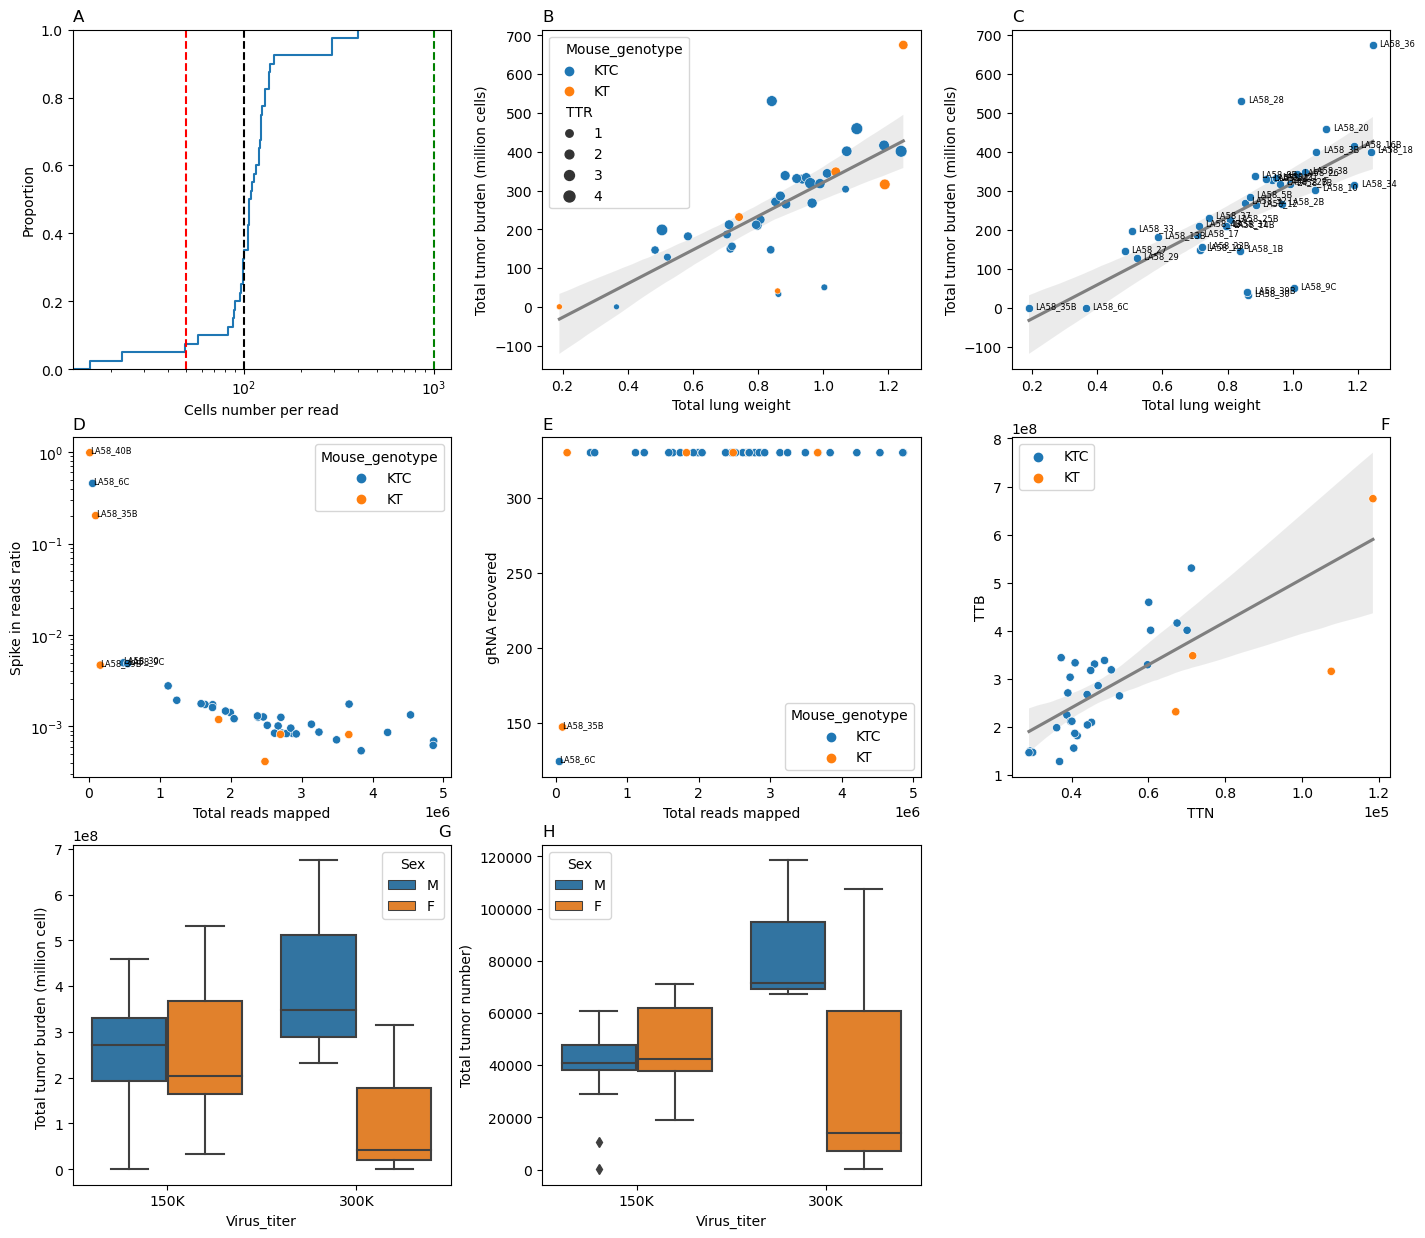

In [75]:
gs = gridspec.GridSpec(3, 17) 
fig1 = plt.figure(figsize=(17,15))

ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = Sample_summary_df
sns.ecdfplot(data=temp_df, x="Cell_number_per_read",ax = ax1)
ax1.set_xlabel('Cells number per read')
ax1.set_xscale('log')
ax1.axvline(50,color='red', linestyle='--')
ax1.axvline(100,color='black', linestyle='--')
ax1.axvline(1000,color='green', linestyle='--')
ax1.set_title('A', loc ='left')


ax2=fig1.add_subplot(gs[:1, 6:11])
temp_df = Sample_summary_df[(Sample_summary_df['Total_lung_weight']!= 0)&(~Sample_summary_df['TTB_million'].isna())]
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax2,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, hue = 'Mouse_genotype',ax = ax2,size= 'TTR')
# label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax2.set_xlabel('Total lung weight')
ax2.set_ylabel('Total tumor burden (million cells)')
ax2.set_title('B', loc ='Left')

ax3=fig1.add_subplot(gs[:1, 12:17])
sns.regplot(x='Total_lung_weight', y='TTB_million', data=temp_df, fit_reg=True ,ax= ax3,scatter=False,color = 'tab:grey')
sns.scatterplot(x='Total_lung_weight', y='TTB_million', data=temp_df, ax = ax3)
label_point(temp_df['Total_lung_weight'], temp_df['TTB_million'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax3.set_xlabel('Total lung weight')
ax3.set_ylabel('Total tumor burden (million cells)')
ax3.set_title('C', loc ='Left')


ax4 = fig1.add_subplot(gs[1:2, 0:5])
sns.scatterplot(x='TTR', y='Spikein_read_ratio', data=Sample_summary_df, hue='Mouse_genotype', ax= ax4)
temp_df = Sample_summary_df[Sample_summary_df.TTR<1000000] # < 1 million reads
label_point(temp_df['TTR'], temp_df['Spikein_read_ratio'], temp_df['Sample_ID'], plt.gca()) # this is for labeling
ax4.set_yscale('log')
ax4.set_title('D', loc ='Left')
ax4.set_xlabel('Total reads mapped')
ax4.set_ylabel('Spike in reads ratio')




ax5 = fig1.add_subplot(gs[1:2, 6:11])

sns.scatterplot(x='TTR', y='gRNA_recovered',data=Sample_summary_df,hue='Mouse_genotype', ax= ax5)

temp_df = Sample_summary_df[Sample_summary_df.gRNA_recovered<300] # < 1 million reads
label_point(temp_df['TTR'], temp_df['gRNA_recovered'], temp_df['Sample_ID'], plt.gca()) # this is for labeling

ax5.set_xlabel('Total reads mapped')
ax5.set_ylabel('gRNA recovered')
ax5.set_title('E', loc ='left')


temp_df = Sample_summary_df[Sample_summary_df.TTR>1000000] # I request at least 1 million reads
ax6 = fig1.add_subplot(gs[1:2, 12:17])
sns.regplot(x='TTN', y='TTB', data=temp_df, fit_reg=True ,ax= ax6,scatter=False,color = 'tab:grey')
sns.scatterplot(x='TTN', y='TTB', data=temp_df, hue='Mouse_genotype', ax= ax6)
# ax6.set_yscale('log')
ax6.set_title('F', loc ='Right')
ax6.set_xlabel('TTN')
ax6.set_ylabel('TTB')
# ax6.xaxis.major.formatter._useMathText = True
ax6.ticklabel_format(axis='both',style='sci',scilimits=(-3,4))
ax6.legend(loc='upper left')


ax7 = fig1.add_subplot(gs[2:3, :5])
sns.boxplot(x='Virus_titer', y='TTB', data=Sample_summary_df, hue='Sex', ax= ax7)
ax7.set_title('G', loc ='right')
ax7.set_ylabel('Total tumor burden (million cell) ')

ax8 = fig1.add_subplot(gs[2:3, 6:11])
sns.boxplot(x='Virus_titer', y='TTN', data=Sample_summary_df, hue='Sex', ax= ax8)
ax8.set_title('H', loc ='Left')
ax8.set_ylabel('Total tumor number)')
# fig1.savefig(figure_output_address+'QC_Saturation.pdf')

In [76]:
Sample_summary_df.sort_values(by = 'TTR')

,Sample_ID,gRNA_recovered,TTB,TTN,TTB_million,Mouse_Ear_Tag,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio
33,LA58_40B,NaN,NaN,NaN,NaN,SK1517,KT,F,15 wks,0.2498,300K,No,22.881550,13265,4370.333333,1.159080,0.988391
36,LA58_6C,124.0,2.840380e+05,186.0,0.284038,MT2327,KTC,M,15 wks,0.3653,150K,Yes,57.520851,53166,8083.666667,12.628571,0.456137
27,LA58_35B,147.0,4.331680e+05,200.0,0.433168,CM3676,KT,F,15 wks,0.1900,300K,No,15.499070,95570,6452.000000,2.885558,0.202532
31,LA58_39B,330.0,4.121126e+07,13929.0,41.211258,SK1516,KT,F,15 wks,0.8604,300K,No,397.350993,161064,251.666667,1.592391,0.004688
22,LA58_30,330.0,3.332484e+07,19115.0,33.324835,CM3586,KTC,F,15 wks,0.8628,150K,No,123.558484,487965,809.333333,1.181070,0.004976
39,LA58_9C,330.0,5.054859e+07,10478.0,50.548591,MT2324,KTC,M,15 wks,1.0039,150K,No,112.739572,546635,887.000000,1.130170,0.004868
0,LA58_10,330.0,3.034823e+08,39626.0,303.482336,MT2366,KTC,M,15 wks,1.0691,150K,Yes,291.970803,1117513,1035.666667,7.863636,0.002780
20,LA58_29,330.0,1.282389e+08,36882.0,128.238866,CM3580,KTC,F,15 wks,0.5218,150K,No,125.104254,1239758,799.333333,1.439481,0.001934
18,LA58_27,330.0,1.466610e+08,28927.0,146.661018,CM3578,KTC,M,15 wks,0.4838,150K,No,106.799573,1582766,936.333333,1.184884,0.001775
10,LA58_1B,330.0,1.472744e+08,29877.0,147.274412,MT2280,KTC,M,15 wks,0.8392,150K,No,105.300105,1637667,949.666667,1.140069,0.001740


#### Output

In [77]:
Sample_summary_df.to_csv(sample_summary_address, index = False)

### Conclusion

* <font size="5" color =  red> I will throw away sample LA58_40B,LA58_35B,LA58_6C because it is just having too few reads, and most of them are spike in.</font>
* <font size="5" color =  red> As usual in panel H, the male always has a higher TTN than the female.</font>
* <font size="5" color =  red> Sample with spikein fraction too high, too few reads or not enough sgRNA recovered should be thrown away</font>

In [78]:
Sample_to_throw = ['LA58_40B','LA58_35B','LA58_6C']

## 7 Correlation

### 7.1 Without cell number cutoff

In [79]:
temp_df.head()

,Sample_ID,gRNA_recovered,TTB,TTN,TTB_million,Mouse_Ear_Tag,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio
0,LA58_10,330.0,3.034823e+08,39626.0,303.482336,MT2366,KTC,M,15 wks,1.0691,150K,Yes,291.970803,1117513,1035.666667,7.863636,0.002780
1,LA58_11,330.0,3.294262e+08,59777.0,329.426248,MT2369,KTC,M,15 wks,0.9362,150K,No,123.813454,2867649,807.666667,1.855046,0.000845
2,LA58_12,330.0,2.647565e+08,52475.0,264.756546,MT2356,KTC,M,15 wks,0.8861,150K,No,110.946746,2668853,901.333333,1.188264,0.001013
3,LA58_13B,330.0,1.819406e+08,41473.0,181.940628,MT2358,KTC,M,15 wks,0.5849,150K,No,105.894811,1994498,944.333333,1.310727,0.001420
4,LA58_14B,330.0,2.096774e+08,45188.0,209.677428,MT2370,KTC,F,15 wks,0.7982,150K,No,99.436526,2385678,1005.666667,1.912742,0.001265


/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/4290004056.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_cor_matrix = Generate_DF_for_Correlation(input_df,unit_name,trait_of_interest).corr(method=input_method, min_periods=1)


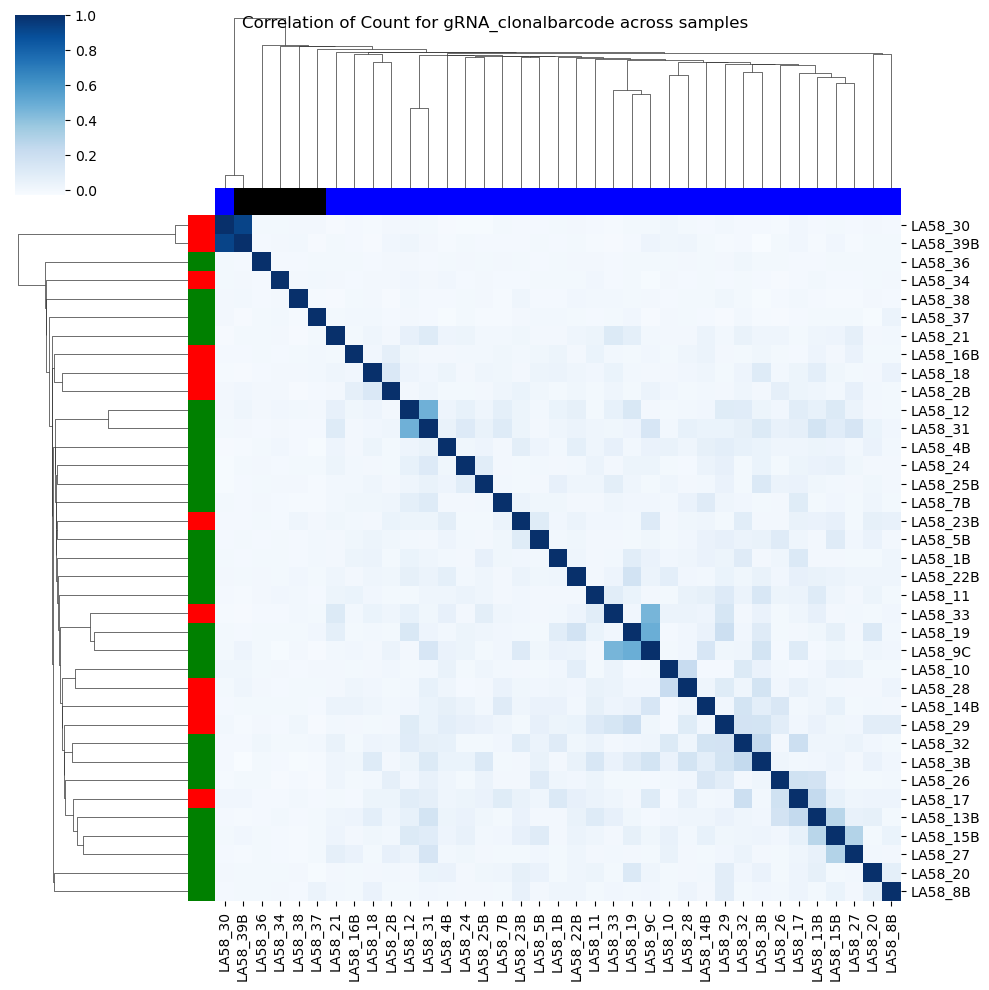

In [80]:
# temp_df = raw_summary_df[(raw_summary_df['Identity']=='gRNA')]
temp_df = Final_df[(Final_df['Identity']=='gRNA')&(~Final_df.Sample_ID.isin(Sample_to_throw))]
# Plot_Correlation_Plot(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",figure_output_address+'SSA_3511.pdf','centroid')
Plot_Correlation_Plot(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",False,'single')

### 7.1 Witt cell number cutoff

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/4290004056.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_cor_matrix = Generate_DF_for_Correlation(input_df,unit_name,trait_of_interest).corr(method=input_method, min_periods=1)


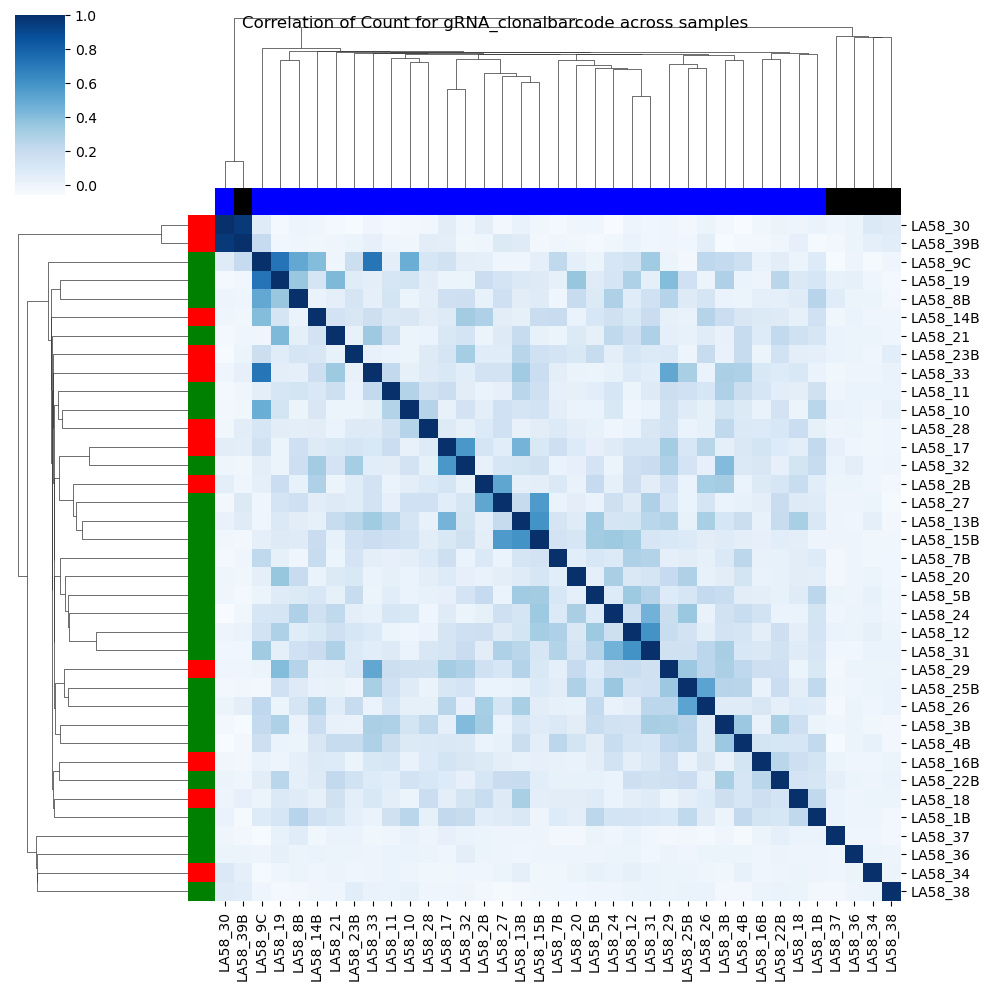

In [81]:
# temp_df = raw_summary_df[(raw_summary_df['Identity']=='gRNA')]
temp_df = Final_df[(Final_df['Identity']=='gRNA')&(~Final_df.Sample_ID.isin(Sample_to_throw))&(Final_df.Cell_number>800)]
Plot_Correlation_Plot(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",False,'single')

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_16952/4290004056.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_cor_matrix = Generate_DF_for_Correlation(input_df,unit_name,trait_of_interest).corr(method=input_method, min_periods=1)


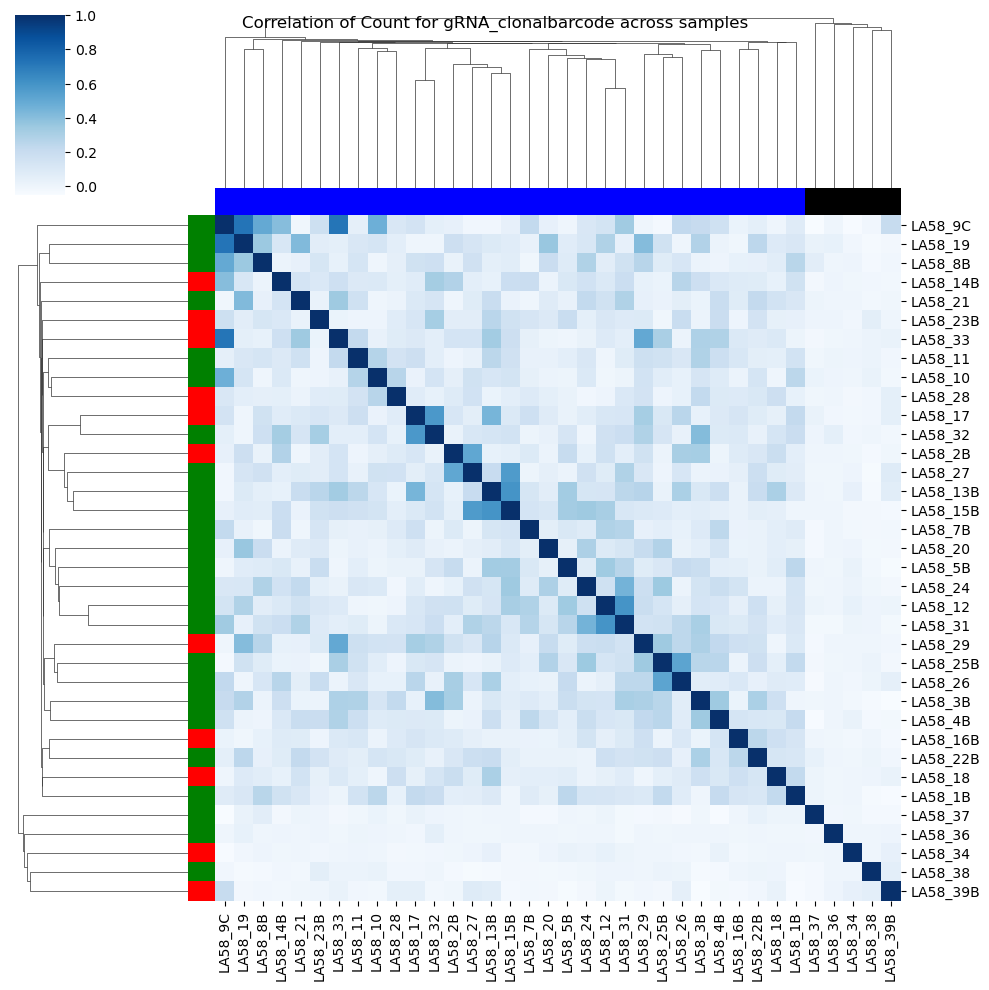

In [82]:
# temp_df = raw_summary_df[(raw_summary_df['Identity']=='gRNA')]
temp_df = Final_df[(Final_df['Identity']=='gRNA')&(~Final_df.Sample_ID.isin(Sample_to_throw+['LA58_30']))&(Final_df.Cell_number>800)]
Plot_Correlation_Plot(temp_df,'gRNA_clonalbarcode','Count','pearson',"Blues",False,'single')

* <font size="5" color =  red> I will throw away sample LA58_30, because it behave like KT mice</font>

In [83]:
Final_Sample_to_throw = Sample_to_throw + ['LA58_30']

In [84]:
with open(sample_discarded_list_address,'w') as handler:
    for x in Final_Sample_to_throw:
        handler.write(x+'\n')